In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as transforms
from  torchvision.datasets import ImageFolder
from torch.autograd import Variable
import cv2
import numpy as np
import os, random,sys
import torch.nn.functional as F

# Build a Variational Autoencoder (VAE) for a human face dataset

We will use a dataset containing images of people and train a variational autoencoder on it.

## Step 1

Download and unzip the ``lfw.zip`` file . Adjust the ``path`` variable so that it contains the address of the unzipped folder. We will create a dataloader from this folder.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
! unzip '/content/drive/MyDrive/lfw.zip'

In [4]:
path = '/content/lfw'

In [5]:
transform    = transforms.Compose([transforms.ToTensor()])
dataloader = DataLoader(ImageFolder(path, transform,),batch_size=32, shuffle=True)

This project is compute intensive. If you have a cuda or mps device on your laptop make sure you use that in the training.

In [6]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    print ("MPS device not found.")

print(device)


cuda


torch.Size([250, 250, 3])


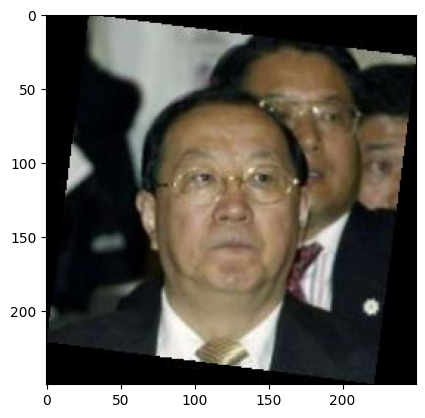

In [7]:
for x,y in dataloader:
    x = x[0].permute(1, 2, 0)
    print(x.shape)
    plt.imshow(x)
    break

# Step 2
The basis for this project is that you can alter your implementation of AutoEncoders from the previous homework and add the necessary bits for a VAE.  Clearly state what is the difference between AutoEncoders and VAEs in terms of Applications, Architecture and Loss function.

## Autoencoders vs Variational Autoencoders (VAEs)

### Applications:

**Autoencoders (AEs):**
- **Data Compression and Denoising:** Traditional autoencoders are primarily used for compressing data representations and denoising input data.
- **Feature Learning:** AEs learn useful features from the input data, capturing relevant patterns.

**Variational Autoencoders (VAEs):**
- **Generative Modeling:** VAEs are designed for generative tasks and can generate new samples that resemble the training data.
- **Data Synthesis and Creativity:** VAEs are often applied in creative tasks, generating novel content, such as images or text.

### Architecture:

**Autoencoders (AEs):**
- **Deterministic Mapping:** AEs have a deterministic encoder that maps input data to a fixed latent representation.
- **Encoding and Decoding Layers:** Typically consist of an encoder and a decoder, connected by a bottleneck layer representing the latent space.

**Variational Autoencoders (VAEs):**
- **Probabilistic Mapping:** VAEs incorporate probabilistic elements, with the encoder producing both mean and log variance of the latent space.
- **Reparameterization Trick:** VAEs introduce a reparameterization trick during sampling to make the model differentiable, allowing backpropagation through the stochastic process.
- **Latent Space Regularization:** VAEs enforce a regularization term, often the Kullback-Leibler (KL) divergence, to encourage the latent space to follow a specific distribution (usually a standard normal distribution).

### Loss Function:

**Autoencoders (AEs):**
- **Reconstruction Loss:** AEs typically use a reconstruction loss, such as Mean Squared Error (MSE), to measure the difference between the input and the reconstructed output.

**Variational Autoencoders (VAEs):**
- **Reconstruction Loss + KL Divergence:** VAEs use a combination of a reconstruction loss (e.g., MSE) and a regularization term, usually the KL divergence. The KL divergence ensures that the learned latent space is close to a specified distribution, often a standard normal distribution.

### Conclusion:

While both autoencoders and variational autoencoders share the basic idea of learning compact representations, VAEs go a step further by introducing probabilistic elements, making them particularly well-suited for generative tasks and creative applications. The architecture and loss functions of VAEs reflect their emphasis on learning a structured and continuous latent space.

# Step 3

Update your pytorch autoencoder model class to create your VAE. Assume the encoder produces the mean and log variance of the latent space.  

**Create separate functions for the encoder and decoder.**

In [8]:
class VAE(nn.Module):

    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim

        # Encoder Layers
        self.enc_conv1 = nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1)
        self.enc_avgpool1 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.enc_conv2 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)

        # Fully connected layers for mean and log variance
        self.fc_mean = nn.Linear(128 * 32 * 32, latent_dim)
        self.fc_logvar = nn.Linear(128 * 32 * 32, latent_dim)
        self.enc_padding = nn.ZeroPad2d((0, 1, 0, 1))

        # Decoder Layers
        self.decoder_fc = nn.Linear(latent_dim, 128 * 32 * 32)
        self.dec_upsample1 = nn.Upsample(size=(62, 62), mode='nearest')
        self.dec_conv1 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
        self.dec_upsample2 = nn.Upsample(size=(125, 125), mode='nearest')
        self.dec_conv2 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)
        self.dec_upsample3 = nn.Upsample(size=(250, 250), mode='nearest')
        self.dec_conv3 = nn.ConvTranspose2d(32, 3, kernel_size=3, stride=1, padding=1)

    def encoder(self, x):
        x = F.relu(self.enc_conv1(x))
        x = self.enc_avgpool1(x)
        x = F.relu(self.enc_conv2(x))
        x = self.enc_padding(x)
        x = x.view(x.size(0), -1)
        mean = self.fc_mean(x)
        logvar = self.fc_logvar(x)
        return mean, logvar

    def decoder(self, x):
        x = self.decoder_fc(x)
        x = x.view(x.size(0), 128, 32, 32)
        x = self.dec_upsample1(x)
        x = F.relu(self.dec_conv1(x))
        x = self.dec_upsample2(x)
        x = F.relu(self.dec_conv2(x))
        x = self.dec_upsample3(x)
        x = self.dec_conv3(x)
        x = torch.sigmoid(x)
        return x

    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mean + eps * std

    def forward(self, x):
        mean, logvar = self.encoder(x)
        z = self.reparameterize(mean, logvar)
        x_recon = self.decoder(z)
        return x_recon, mean, logvar


# Variational Autoencoder (VAE) Implementation

The provided code implements a Variational Autoencoder (VAE) using the PyTorch deep learning framework. VAEs are a type of generative model that not only learns to encode input data into a continuous latent space but also allows for the generation of new samples with meaningful variations. Let's delve into the details of the architecture and training mechanism.

## Model Architecture

### Encoder:
- **Convolutional Layers:** The encoder starts with a convolutional layer (`enc_conv1`) with 3 input channels (for RGB images) and 64 output channels. It applies a kernel of size 4x4, with a stride of 2 and padding of 1, performing downsampling.
- **Average Pooling:** An average pooling layer (`enc_avgpool1`) with a kernel size of 2x2 and a stride of 2 further reduces spatial dimensions.
- **Additional Convolutional Layer:** Another convolutional layer (`enc_conv2`) follows, with 64 input channels and 128 output channels, similar to the first layer.

### Fully Connected Layers:
- Two fully connected layers (`fc_mean` and `fc_logvar`) process the flattened output of the last convolutional layer. These layers output the mean and log variance of the latent space, respectively.
- A padding layer (`enc_padding`) is used to handle odd-sized feature maps produced by the convolutional layers.

### Decoder:
- **Fully Connected Layer:** The latent representation is decoded using a fully connected layer (`decoder_fc`) that transforms it back to a high-dimensional representation.
- **Upsampling Layers:** Three upsampling layers (`dec_upsample1`, `dec_upsample2`, `dec_upsample3`) increase the spatial dimensions of the feature map.
- **Transposed Convolutional Layers:** Three transposed convolutional layers (`dec_conv1`, `dec_conv2`, `dec_conv3`) perform the reconstruction process, gradually increasing spatial dimensions.
- The final layer employs a sigmoid activation function to normalize the output to the range [0, 1].

## Training Mechanism

### Reparameterization Trick:
- The `reparameterize` function applies the reparameterization trick, which involves sampling from a normal distribution defined by the mean and log variance obtained from the encoder. This step introduces stochasticity, making the training process differentiable.

### Forward Method:
- The `forward` method ties the encoder and decoder together. It takes an input `x`, passes it through the encoder to obtain the mean and log variance of the latent space, applies reparameterization to get a latent representation `z`, and finally passes `z` through the decoder to reconstruct the input.

## Usage

- Instantiate the `VAE` class, specifying the desired latent dimension.
- Utilize the `forward` method for reconstructing input images and generating new samples.
- Train the model using appropriate datasets, such as a dataset containing images of faces.

This VAE architecture serves as a foundational structure. Depending on the specific application and dataset, further customization, hyperparameter tuning, and experimentation may be necessary to achieve optimal performance and desired generative capabilities.

## Step 4
Create an instance of the new class, pass an image to the model

*  print the shape of the output of the **encoder**. Explain how would you generate new samples in the latent space. Your explanation should show that you have understood the concepts. Providing just the formula or code snippet without context will not earn any points.
*  use the decoder to create new images. Print the shape of the output and verify that the forward pass is working correctly.

In [9]:
vae_model = VAE(latent_dim=30)
vae_model = vae_model.to(device)

In [10]:
# Load the dataset and get a random image
dataiter = iter(dataloader)
images, labels = next(dataiter)
random_index = torch.randint(len(images), size=(1,)).item()
random_image = images[random_index].unsqueeze(0).to(device)

print(random_image.shape)

torch.Size([1, 3, 250, 250])


In [11]:
# Passing the random image through the model
encoded_output, mu, logvar = vae_model(random_image)
z_reparam = vae_model.reparameterize(mu, logvar)
reconstructed_img = vae_model.decoder(z_reparam)

# Printing the shape of the outputs
encoded_shapes = (mu.shape, logvar.shape)
reconstructed_shape = reconstructed_img.shape

print("Encoded shapes (mean, logvar):", encoded_shapes)
print("Reconstructed image shape:", reconstructed_shape)

Encoded shapes (mean, logvar): (torch.Size([1, 30]), torch.Size([1, 30]))
Reconstructed image shape: torch.Size([1, 3, 250, 250])



## How to Generate New Samples in the Latent Space:
To generate new samples in the latent space, you can use the reparameterization trick. This involves sampling from a normal distribution defined by the mean (mu) and log variance (logvar) obtained from the encoder. The sampled latent representation (z_reparam) is then passed through the decoder to generate new samples.

In the provided code:

z_reparam represents the sampled latent representation using the reparameterization trick.
The decoder is used to reconstruct an image from the sampled latent representation.
This process allows for the generation of new samples in the latent space, providing a way to explore and create variations in the learned representations. The reparameterization ensures that the sampling is differentiable, allowing backpropagation during training.




## Explanation:

Instantiate the VAE Model:

Create an instance of the Variational Autoencoder (VAE) class with a specified latent dimension (30 in this case).
Move the model to the specified device (e.g., GPU).
Load a Random Image:

Use the DataLoader to get a batch of images and select a random image from the batch.
Add a batch dimension and move the image to the specified device.
Print the Shape of the Random Image:

Print the shape of the randomly selected image. This helps understand the input dimensions.
Pass the Image Through the Model:

Forward pass the random image through the VAE model to obtain the mean (mu) and log variance (logvar) of the latent space.
Apply the reparameterization trick to obtain a latent representation (z_reparam).
Reconstruct an image using the decoder.
Print the Shapes of the Outputs:

Print the shapes of the mean and log variance obtained from the encoder.
Print the shape of the reconstructed image obtained from the decoder.









##  Step 5
* Print the total number of parameters in the model
* Explain what loss should be used here. Describe in your own words the terms of the loss function and what goal each term of the loss function achieves. Your explanation should show that you have understood the concepts. Providing just the formula or code snippet without context will not earn any points.


* create an optimizer for training

In [12]:
total_params = sum(p.numel() for p in vae_model.parameters())
print(f"Total number of parameters in the model: {total_params}")

Total number of parameters in the model: 12226751


In [13]:
import torch.optim as optim
optim = optim.Adam(vae_model.parameters(), lr=0.001)

In [14]:
def vae_loss_function_mse(reconstructed_x, original_x, mu, logvar):
    recon_loss = F.mse_loss(reconstructed_x, original_x, reduction='sum')

    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    total_loss = recon_loss + kl_div
    return total_loss


**Explanation:**

1. **Total Parameters:**
   - The `total_params` calculation counts the number of parameters in the VAE model. These parameters include weights and biases in both the encoder and decoder networks. Knowing the total parameters is crucial for understanding the model's capacity and potential for overfitting.

2. **Optimizer Creation:**
   - The `Adam` optimizer is chosen for its adaptive learning rate capabilities. It adjusts learning rates individually for each parameter during training, enhancing convergence. The learning rate of 0.001 is a common starting point and can be tuned based on training progress.

3. **Loss Function Explanation:**
   - **Reconstruction Loss (MSE):**
     - Measures the difference between the reconstructed image (`reconstructed_x`) and the original input image (`original_x`).
     - Mean Squared Error (MSE) is used, quantifying the average squared pixel-wise differences.
     - The `reduction='sum'` argument sums up the MSE values, providing a scalar loss value.

   - **KL Divergence Loss:**
     - Measures the divergence between the learned latent space distribution and a predefined distribution (usually a standard normal distribution).
     - Encourages the learned latent space to follow a specific structure, introducing regularization.
     - Computed using the mean (`mu`) and log variance (`logvar`) outputted by the encoder.

   - **Total VAE Loss:**
     - The total VAE loss is a combination of the reconstruction loss and the KL divergence loss.
     - Balances the fidelity of reconstructed samples and the regularization of the latent space.
     - Minimizing this combined loss during training results in a well-structured latent space capable of generating meaningful samples.

Understanding these concepts is vital for successful VAE training. The combination of reconstruction and KL divergence losses reflects the dual objective of accurate reconstruction and regularization, striking a balance between faithful representation and controlled latent space structure. The optimizer facilitates the minimization of this composite loss during training.

##  Step 6
Write a training loop and start training the model for several epochs. Report the loss value at the end of each epoch and monitor it. If your loss is not decreasing what do you have to do to troubleshoot it ?

In [52]:
# Training Loop
epochs = 10
for epoch in range(epochs):
    total_loss = 0
    for batch in dataloader:
        inputs = batch[0].to(device)

        # Forward pass
        optim.zero_grad()
        reconstructed, mu, logvar = vae_model(inputs)

        # Compute loss
        loss = vae_loss_function_mse(reconstructed, inputs, mu, logvar)

        # Backward pass and optimize
        loss.backward()

        optim.step()

        total_loss += loss.item()

    total_loss = total_loss / len(dataloader)
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss:.7f}")

Epoch 1/10, Loss: 116811.6364734
Epoch 2/10, Loss: 115429.3759435
Epoch 3/10, Loss: 113910.6823105
Epoch 4/10, Loss: 112759.5943539
Epoch 5/10, Loss: 111779.4807896
Epoch 6/10, Loss: 110282.9632586
Epoch 7/10, Loss: 109276.5249849
Epoch 8/10, Loss: 108237.7677008
Epoch 9/10, Loss: 107243.6713749
Epoch 10/10, Loss: 106093.2810236


### Training Loop for a Variational Autoencoder (VAE)

The provided code represents a training loop for a Variational Autoencoder (VAE) using PyTorch. Let's explore the key components of this loop and how it operates:

#### Loop Structure

- *Epoch Iteration*: The loop runs for a predefined number of epochs (epochs = 30). Each epoch represents a full pass through the entire dataset.

- *Batch Processing*: Within each epoch, the loop iterates over batches of data from the dataloader. This batch-wise approach is typical in neural network training for efficiency and effectiveness.

#### Forward Pass

- *Data Preparation*: For each batch, the input data (inputs) is transferred to the appropriate device (like a GPU).

- *Model Forward Pass*: The VAE model processes the input data. The vae_model(inputs) call returns the reconstructed output, the mean (mu), and the log variance (logvar) of the latent space.

#### Loss Computation

- *Loss Calculation*: The vae_loss_function_mse function computes the loss for the VAE. This function typically includes two components:
  1. *Reconstruction Loss*: It measures how well the VAE can reconstruct the input data. Usually, this is a Mean Squared Error (MSE) between the original input and the reconstructed output.
  2. *KL Divergence Loss*: This part of the loss ensures that the learned latent space distribution (represented by mu and logvar) stays close to a prior distribution (typically a standard normal distribution).

#### Backward Pass and Optimization

- *Gradient Computation and Parameter Update*:
  - The loss.backward() computes the gradients of the loss with respect to the model parameters.
  - optim.step() updates the model parameters using the computed gradients. The optimizer (referred to as optim here) adjusts the weights to minimize the loss.

#### Monitoring and Troubleshooting

- *Loss Monitoring*: At the end of each epoch, the average loss is printed. This monitoring is crucial for observing the training progress and verifying that the model is learning effectively.
  
- *Troubleshooting Non-Decreasing Loss*:
  - If the loss is not decreasing, it might indicate issues with the learning rate, model architecture, overfitting, or data preprocessing.
  - Adjusting the *learning rate* can sometimes resolve convergence issues.
  - Reviewing and potentially *modifying the model architecture* can also help, especially if the model is too simple or too complex for the task.
  - Implementing techniques to combat *overfitting*, such as dropout or regularization, may be necessary.
  - Ensuring correct *data preprocessing* and *shuffle* in the dataloader can also impact model performance.


##  Step 7

Take a random image from the dataset and plot it together with new samples generated.

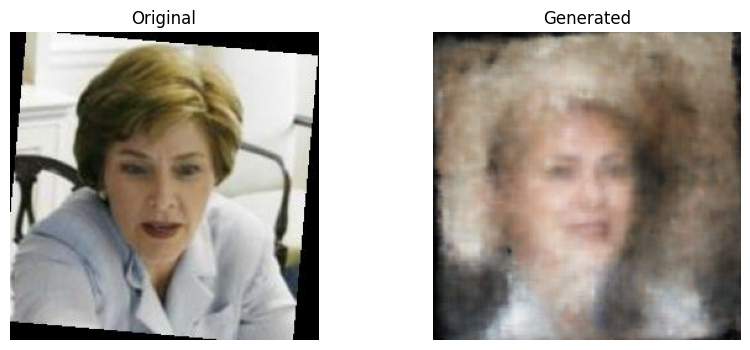

In [64]:
# Function to generate a single sample from the VAE
def generate_sample(vae_model, latent_dim, device=device):
    with torch.no_grad():
        z = torch.randn(1, latent_dim).to(device)
        generated_image = vae_model.decoder(z)
    return generated_image.cpu()

# Select a random image from the dataset
random_index = torch.randint(len(images), size=(1,)).item()
original_image = images[random_index]

# Generate a single image
vae_model.eval()
generated_image = generate_sample(vae_model, latent_dim=30, device=device)

# Convert images to numpy for plotting
original_image_np = original_image.permute(1, 2, 0).numpy()
generated_image_np = generated_image.squeeze().permute(1, 2, 0).numpy()

# Plotting
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(original_image_np)
plt.title("Original")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(generated_image_np)
plt.title("Generated")
plt.axis('off')

plt.show()


This code snippet selects a random image from a dataset and utilizes a trained Variational Autoencoder (VAE) model to generate a new image. The original and generated images are then displayed side by side using matplotlib. The VAE is set to evaluation mode, and a random image is chosen from the dataset. The `generate_sample` function produces a new image by sampling from the VAE's latent space. The resulting images, both original and generated, are converted to NumPy arrays for visualization. The purpose is to visually assess the VAE's ability to generate realistic images and observe how well the generated image corresponds to the randomly selected original image.

Reference: Chatgpt